In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from pathlib import Path
from datetime import datetime
from matplotlib import pyplot as plt
import datetime

In [3]:
from scipy.stats import shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.discrete.discrete_model import NegativeBinomial
from scipy.stats import boxcox
from scipy.stats import nbinom
import scipy.stats as stats
import scipy as sp

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
# import modules
from src.features import stat_tests as st
from src.features import calculate_chart_params as cp
from src.features import plot_functions as pf

In [6]:
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Read in data

In [7]:
data_path = "D:\\Users\\Nicholas\\Projects\\repos\\spc_charts\\data\\raw\\dengue"

#### Read in pre-2012

In [8]:
data0 = pd.read_csv(Path(data_path) / 'dengue-pre2012.csv')

In [9]:
data0 = data0[2:].copy()

In [10]:
data0['week'] = list(range(1,53))*12
data0['year'] = [i for i in list(range(2000, 2012)) for _ in range(52)]
data0 = data0.drop('time', axis=1)

#### Read in pre-2012

In [11]:
post_files = os.listdir(Path(data_path) / 'dengue-post2012')

In [12]:
data = pd.DataFrame()

In [13]:
for i in range(len(post_files)):
    temp = pd.read_csv(Path(data_path) / 'dengue-post2012' / post_files[i])
    temp['year'] = os.path.splitext(post_files[i])[0]
    data = pd.concat([data, temp], axis=0, ignore_index=True)

In [14]:
data.columns = ['week', 'cases', 'year']

In [15]:
data = pd.concat([data0, data], axis=0, ignore_index=True, sort=True)

In [16]:
data['datetime'] = data['year'].astype('str') + '-' + data['week'].astype('str')

In [17]:
data['datetime'] = data['datetime'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y-%W-%w"))
data['datetime'] = pd.to_datetime(data['datetime'])

#### Read in pop

In [18]:
pop = pd.read_csv(Path(data_path) / 'population-sg.csv')

In [19]:
pop['population'] = pop['population'].str.replace(',', '').astype('float')

In [20]:
data['year'] = data['year'].astype('int64')

In [21]:
data = data.merge(pop, on='year', how='left')

In [22]:
data['norm_cases'] = data['cases'] / data['population'] * 1000000

#### Plot

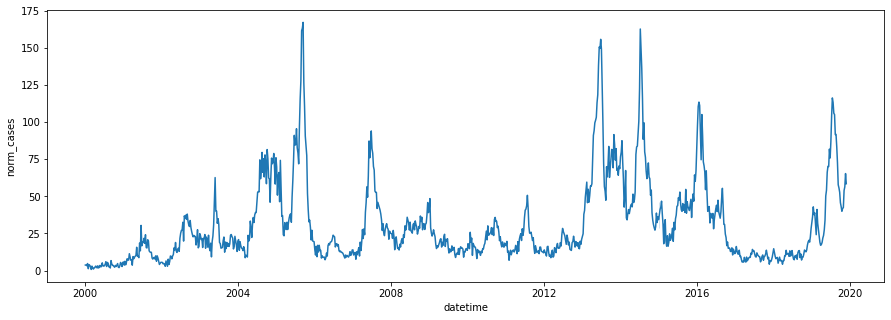

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='datetime', y='norm_cases', data=data, kind='line', ax=ax)
plt.close()

#### Get subset of data

In [24]:
data_filter = (data['datetime'] >= '2008') & (data['datetime'] < '2014')

In [25]:
in_control_filter = (data['datetime'] >= '2008') & (data['datetime'] < '2013')

In [26]:
cutoff = '2013'

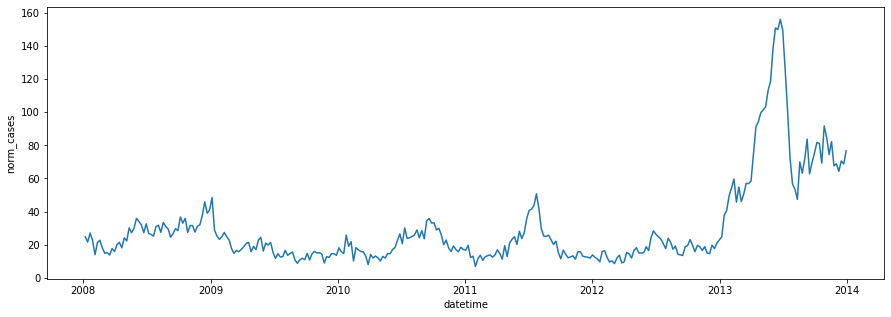

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='datetime', y='norm_cases', data=data[data_filter], kind='line', ax=ax)
plt.close()

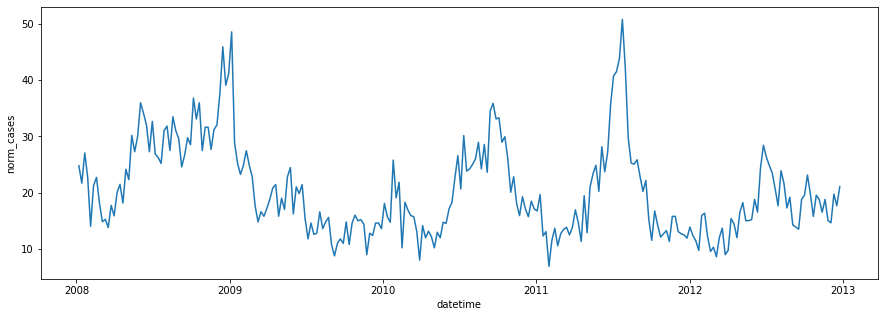

In [28]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='datetime', y='norm_cases', data=data[in_control_filter], kind='line', ax=ax)
plt.close()

#### Test for auto correlation

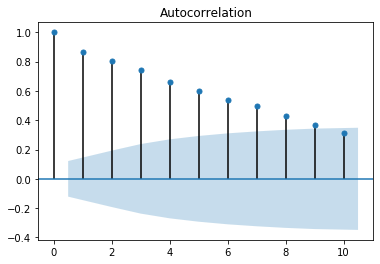

In [29]:
_ = plot_acf(data.loc[in_control_filter, 'norm_cases'], lags=10)

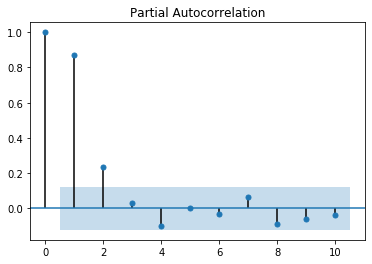

In [30]:
_ = plot_pacf(data.loc[in_control_filter, 'norm_cases'], lags=10)

In [31]:
st.ljungbox_(data.loc[in_control_filter, 'norm_cases'], print_extra=True)

Statistics=986.606, p=0.000
There is correlation up to lag 10 (reject H0)


[197.43414394 369.48377044 515.9545599  632.85131576 729.74917689
 806.83920595 872.68485848 922.46345303 959.52133211 986.60612552]
[7.58187803e-045 5.85623738e-081 1.66332053e-111 1.20150305e-135
 1.81277138e-155 5.12542157e-171 3.79640771e-184 8.05453373e-194
 9.19825259e-201 1.43540546e-205]


#### Try simple AR2 model

In [32]:
data2 = data.loc[data_filter, ['datetime', 'norm_cases']]

In [33]:
data2['x1'] = data2['norm_cases'].shift(periods = 1)
data2['x2'] = data2['norm_cases'].shift(periods = 2)

In [34]:
df_full = data2.dropna().copy()
df_train = df_full.loc[df_full['datetime'] < cutoff, ].copy()

In [35]:
features = ['x1', 'x2']

In [36]:
lm = LinearRegression(fit_intercept=True)
lm.fit(df_train.loc[:, features].values, df_train['norm_cases'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
lm.intercept_, lm.coef_

(2.0879458125971873, array([0.67142991, 0.22552704]))

In [38]:
# get residuals
residuals = pd.Series(df_train['norm_cases'].values - lm.predict(df_train.loc[:, features].values))

#### Test for Autocorrelation

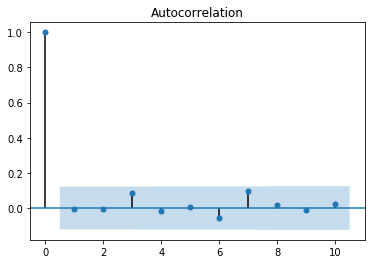

In [39]:
_ = plot_acf(residuals, lags=10)

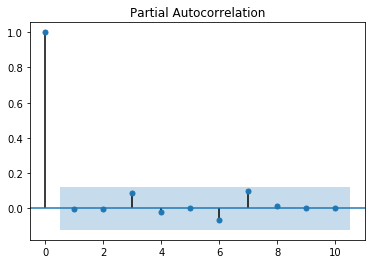

In [40]:
_ = plot_pacf(residuals, lags=10)

In [41]:
st.ljungbox_(residuals, print_extra=True)

Statistics=5.458, p=0.859
No auto correlation up to lag 10 (fail to reject H0)


[3.65857879e-03 1.22614929e-02 1.97898980e+00 2.07340646e+00
 2.07720845e+00 2.85744913e+00 5.22497765e+00 5.30891651e+00
 5.33719948e+00 5.45793717e+00]
[0.95176842 0.99388801 0.57677888 0.72225949 0.83836196 0.82651408
 0.63252925 0.72410586 0.80397908 0.85856701]


#### Hypothesis test for normality

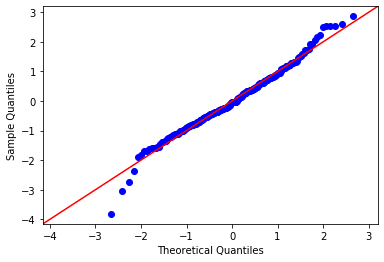

In [42]:
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()

In [43]:
st.shapiro_wilks_(residuals)

Statistics=0.987, p=0.018
Sample does not look Gaussian (reject H0)


In [44]:
st.jarque_bera_(residuals)

Statistics=8.997, p=0.011, skew=0.043, kurt=3.911
Sample does not look Gaussian (reject H0)


#### Test without outliers (Assume 1% outliers)

In [45]:
# Test without outliers
residuals2 = residuals[residuals.between(residuals.quantile(.005), residuals.quantile(.995))]

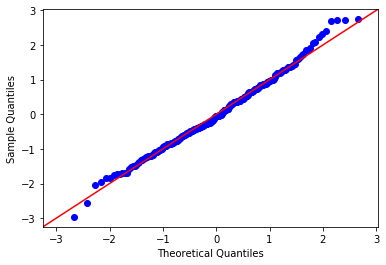

In [46]:
fig = sm.qqplot(residuals2, fit=True, line='45')
plt.show()

In [47]:
st.shapiro_wilks_(residuals2)

Statistics=0.992, p=0.217
Sample looks Gaussian (fail to reject H0)


In [48]:
st.jarque_bera_(residuals2)

Statistics=2.847, p=0.241, skew=0.249, kurt=3.145
Sample looks Gaussian (fail to reject H0)


#### Individual control chart for residuals

In [49]:
in_control_mean = 0

In [50]:
MR = cp.calculate_MR(residuals)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [51]:
in_control_mean, in_control_sigma

(0, 3.887227440279198)

In [52]:
full_residuals = pd.Series(df_full['norm_cases'].values - lm.predict(df_full.loc[:, features].values))

In [53]:
x_ind_params_df = cp.x_ind_params(x=full_residuals, sigma = in_control_sigma, center=in_control_mean)
x_ind_params_df = pd.concat([df_full.loc[:, 'datetime'].reset_index(drop=True), x_ind_params_df], axis=1)

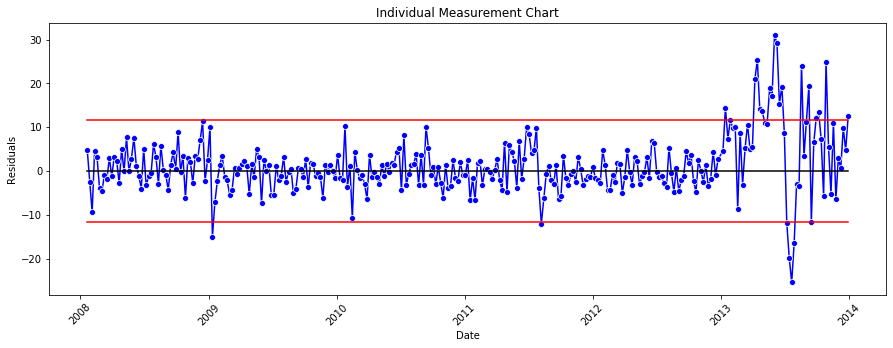

In [54]:
pf.plot_control_chart(
    data = x_ind_params_df,
    index = 'datetime',
    obs = 'obs',
    UCL = 'UCL',
    center = 'Center',
    LCL = 'LCL',
    title='Individual Measurement Chart',
    ylab='Residuals',
    xlab='Date',
    all_dates=False,
    rot=45)

In [55]:
x_ind_params_df['datetime'][x_ind_params_df['obs'] > x_ind_params_df['UCL']][0:5]

259   2013-01-14
271   2013-04-08
272   2013-04-15
273   2013-04-22
274   2013-04-29
Name: datetime, dtype: datetime64[ns]

#### Plot original measure chart

In [56]:
def convert_residuals_to_original(chart_df, predictions, features=["obs", "UCL", "Center", "LCL"]):
    chart_df = chart_df.copy()
    chart_df.loc[:, features] = (
        chart_df.loc[:, features].values + predictions[:, None]
    )
    return chart_df

In [57]:
x_ind_params_df2 = convert_residuals_to_original(chart_df = x_ind_params_df, 
                                                 predictions = lm.predict(df_full.loc[:, features].values))

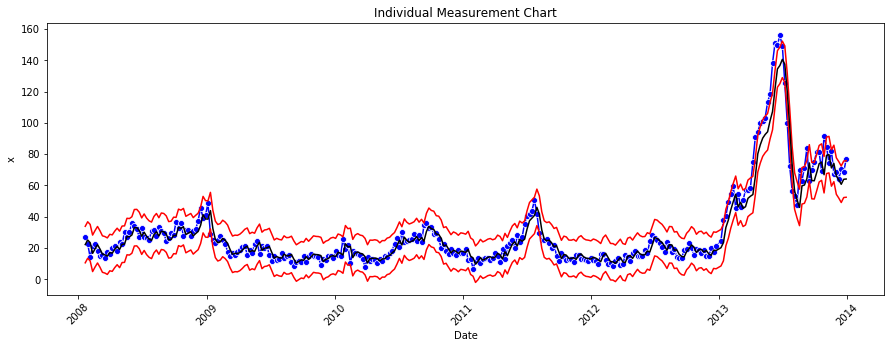

In [58]:
pf.plot_control_chart(
    data = x_ind_params_df2,
    index = 'datetime',
    obs = 'obs',
    UCL = 'UCL',
    center = 'Center',
    LCL = 'LCL',
    drawstyle='default',
    title='Individual Measurement Chart',
    ylab='x',
    xlab='Date',
    all_dates=False,
    rot=45)

In [59]:
x_ind_params_df2['datetime'][x_ind_params_df2['obs'] > x_ind_params_df2['UCL']][0:5]

259   2013-01-14
271   2013-04-08
272   2013-04-15
273   2013-04-22
274   2013-04-29
Name: datetime, dtype: datetime64[ns]

#### Zoom in to out of control process

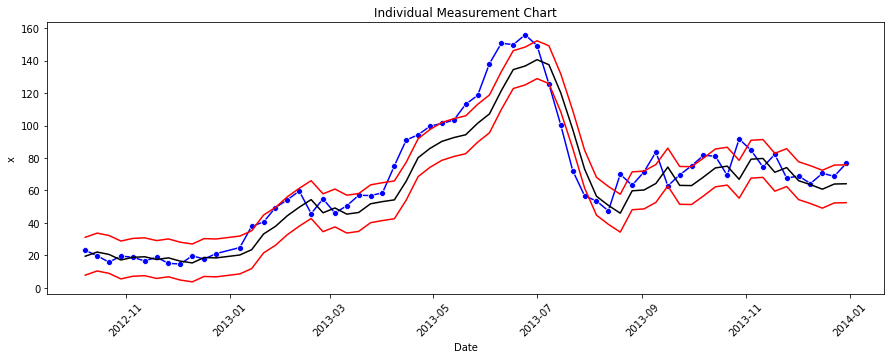

In [60]:
pf.plot_control_chart(
    data = x_ind_params_df2[x_ind_params_df2['datetime'] > '2012-10'],
    index = 'datetime',
    obs = 'obs',
    UCL = 'UCL',
    center = 'Center',
    LCL = 'LCL',
    drawstyle='default',
    title='Individual Measurement Chart',
    ylab='x',
    xlab='Date',
    all_dates=False,
    rot=45)